## 安裝Dlib (For Python 3.6)
1. 請先安裝下列六個套件：
* pip install numpy scipy matplotlib scikit-learn jupyter
* pip install opencv-python
2. 再行安裝Dlib，但勿使用pip至CMD下載，請至Dlib官網下載：
* pip install dlib
* Dlib官網下載包 https://pypi.org/simple/dlib/ (找dlib-19.8.1-cp36-cp36m-win_amd64.whl)

## 使用Dlib抓取臉部特徵點

* 建立一face_feature方法：
    * 輸入為影像、人臉偵測器(變數名稱取detector)以及人臉特徵器(變數名稱取predictor)
    * 人臉偵測器需代入彩色影像，人臉特徵器需代入灰階影像
    * 使用for迴圈將人臉偵測器中的多個人臉(face)作處理
    * 使用for迴圈將人臉特徵器獲取的人臉特徵位置（landmarks）繪至圓圈
    * 輸出為人臉抓取特徵點後的影像
* 獲取攝像機的影像，並測試face_feature的方法

#### 臉部特徵偵測器之檔案，在下列連結：
1. https://drive.google.com/file/d/1KSbJutlhnxhKPXXx6jY_mv3tT3AlMzsQ/view?usp=sharing
2. https://drive.google.com/file/d/1IOl02sxBMZCYyQP0Rgpra9FrwSy2y-jV/view?usp=sharing

In [4]:
#匯入套件(模塊)
import dlib
import cv2

#人臉特徵器
detector = dlib.get_frontal_face_detector()

#人臉辨識器
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

#建立face_feature方法
def face_feature(img, detector, predictor):
    
    #改變攝影機傳入的影像大小
    img = cv2.resize(img, None, fx=0.8, fy=0.8)
    
    #將影像帶入Dlib的人臉偵測器
    face = detector(img)

    #轉成灰階影像
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    for face in face:
    
        # 使用灰階影像偵測臉特徵的詳細位置
        landmarks = predictor(img_gray, face)
        
        # 獲得鼻子上方、中間、左邊及右邊的座標位置
        for i in range(67):
            cv2.circle(img, (landmarks.part(i).x, landmarks.part(i).y), 5, (0,255,255), -1)

    return img

In [5]:
#讀取攝影機或影片
VIDEO_IN = cv2.VideoCapture(0)
#VIDEO_IN = cv2.VideoCapture("Video3.mp4") 

#無限迴圈來讀取影像
while True:
    hasFrame, frame = VIDEO_IN.read()

    #影像代入face_feature方法
    img = face_feature(frame, detector, predictor)
    
    #顯示畫面
    cv2.imshow("Frame", img)
    
    #當按下q鍵時，跳離無限迴圈
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

#銷毀影像視窗
VIDEO_IN.release()
cv2.destroyAllWindows()

## 使用Yolo的人臉辨識結合Dlib臉部特徵器
* 建立yolo_location方法：
    * 與以往程式碼相同，不同地方為：
        * 輸出回傳位置與標籤
        * 不需繪製方框
        * 回傳的位置需要以Dlib的格式

In [2]:
import cv2
import numpy as np

net = cv2.dnn.readNetFromDarknet("yolov3-tiny.cfg","./test_yolov3-tiny_10000.weights")

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

classes = [line.strip() for line in open("cfg_mask/obj2.names")]

def yolo_location(frame):

    height, width, channels = frame.shape 
    
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
    
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids, confidences, boxes = [], [], []
    
    for out in outs:
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            
            scores = detection[5:]
            class_id = np.argmax(scores)  
            if confidence > 0.2:   
                center_x = int(tx * width)
                center_y = int(ty * height)
                w = int(tw * width)
                h = int(th * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.6)
    
    label, location = [], []
    
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label.append(str(classes[class_ids[i]]))
            #location.append([x, y, x+w, y+h])
            location.append(dlib.rectangle(x, y, x+w, y+h))
    return label, location

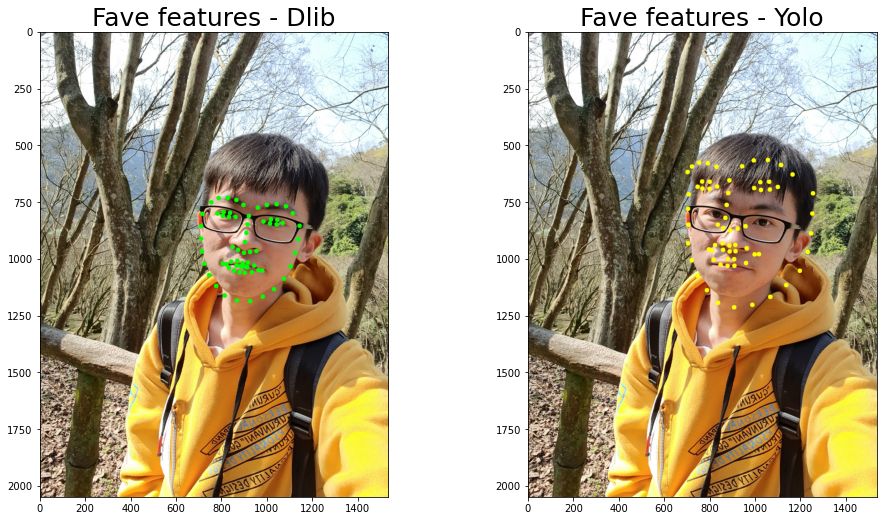

In [24]:
import matplotlib.pyplot as plt

img = cv2.imread("Image_test/Face_test.jpeg")
img_2 = img
img = cv2.resize(img, None, fx=1, fy=1)  

label, location_yolo = yolo_location(img)
location_dlib = detector(img)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

for face in location_dlib:
    landmarks = predictor(img_gray, face)
    for i in range(67):
        cv2.circle(img, (landmarks.part(i).x, landmarks.part(i).y), 10, (0,255,0), -1)
        
for face in location_yolo:
    landmarks = predictor(img_gray, face)
    for i in range(67):
        cv2.circle(img_2, (landmarks.part(i).x, landmarks.part(i).y), 10, (0,255,255), -1)


fig , ax = plt.subplots(figsize=(15,13))
fig.subplots_adjust(hspace=0.4, wspace=0.4) #設定子圖的間隔

plt.subplot(1, 2, 1)
plt.title("Fave features - Dlib", size=25)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Fave features - Yolo", size=25)
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
plt.show()